In [1]:
from xgboost import XGBClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df_final_train = pd.read_hdf('./Facebook/data/fea_sample/storage_sample_stage5.h5', 'train_df',mode='r')
df_final_test = pd.read_hdf('./Facebook/data/fea_sample/storage_sample_stage5.h5', 'test_df',mode='r')

In [3]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [4]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

In [89]:
x_cfl=XGBClassifier(tree_method='gpu_hist',reg_alpha= 10,reg_lambda=1)

prams={
    'learning_rate':[0.1,0.15,0.2],
     'n_estimators':[100,200],
     'max_depth':[3,5,7],
    'colsample_bytree':[0.3,0.5,1],
    'subsample':[0.1,0.3,0.5,1]
}
random_cfl=RandomizedSearchCV(x_cfl,param_distributions=prams,verbose=10,n_jobs=20,scoring='f1')
random_cfl.fit(df_final_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 4/5; 2/10] START colsample_bytree=0.5, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3
[CV 4/5; 2/10] END colsample_bytree=0.5, learning_rate=0.15, max_depth=5, n_estimators=200, subsample=0.3;, score=0.980 total time=  17.5s
[CV 1/5; 7/10] START colsample_bytree=0.5, learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.1
[CV 1/5; 7/10] END colsample_bytree=0.5, learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.1;, score=0.976 total time=   5.2s
[CV 1/5; 8/10] START colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.1
[CV 1/5; 8/10] END colsample_bytree=0.3, learning_rate=0.1, max_depth=5, n_estimators=200, subsample=0.1;, score=0.978 total time=  14.6s
[CV 1/5; 2/10] START colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsample=0.1
[CV 1/5; 2/10] END colsample_bytree=1, learning_rate=0.1, max_depth=5, n_estimators=100, subsam

RandomizedSearchCV(estimator=XGBClassifier(base_score=None, booster=None,
                                           callbacks=None,
                                           colsample_bylevel=None,
                                           colsample_bynode=None,
                                           colsample_bytree=None,
                                           early_stopping_rounds=None,
                                           enable_categorical=False,
                                           eval_metric=None, gamma=None,
                                           gpu_id=None, grow_policy=None,
                                           importance_type=None,
                                           interaction_constraints=None,
                                           learning_rate=None, max_bin=None,
                                           max_c...
                                           min_child_weight=None, missing=nan,
                                   

In [90]:
random_cfl.best_params_

{'subsample': 1,
 'n_estimators': 100,
 'max_depth': 7,
 'learning_rate': 0.2,
 'colsample_bytree': 1}

In [91]:
best_model = random_cfl.best_estimator_

In [92]:
y_train_pred = best_model.predict(df_final_train)
y_test_pred = best_model.predict(df_final_test)

In [93]:
np.unique(y_test,return_counts=True)

(array([0, 1]), array([25046, 24956]))

In [94]:
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

Train f1 score 0.9889324811109662
Test f1 score 0.9285305646784617


In [95]:
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


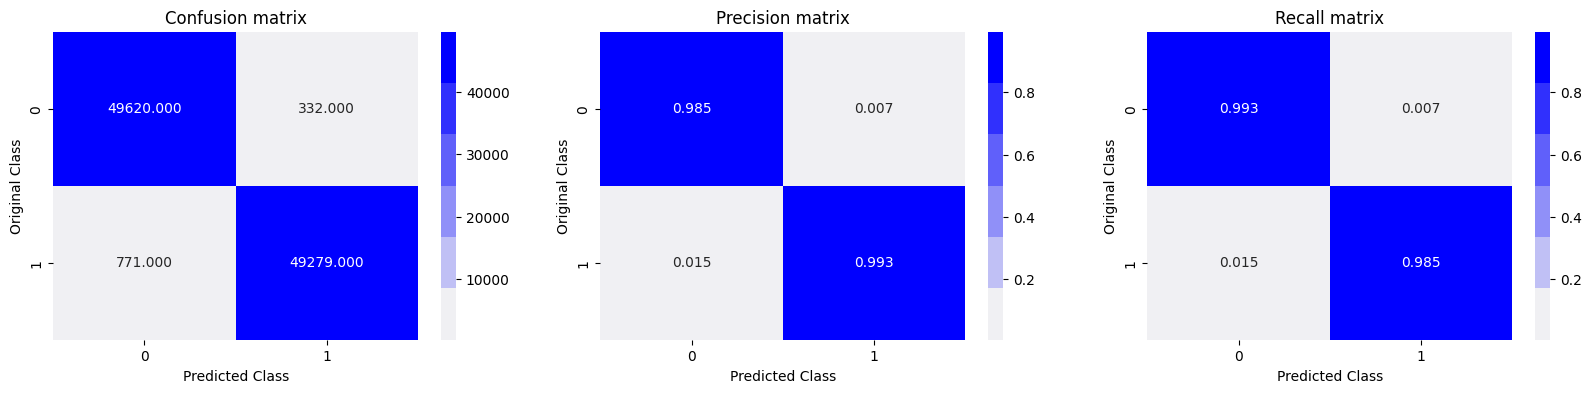

Test confusion_matrix


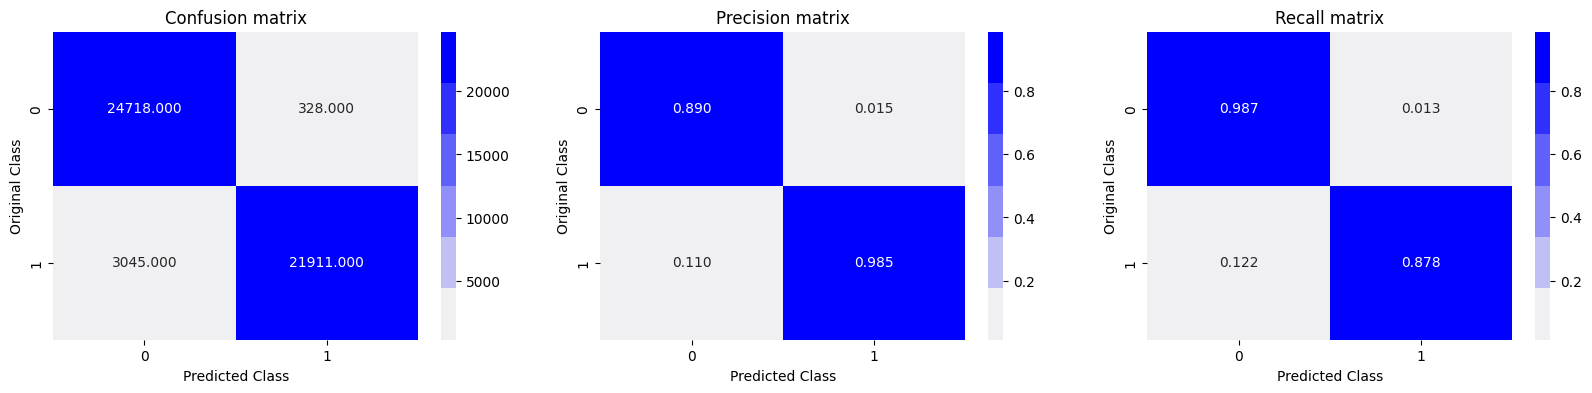

In [96]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

In [97]:
df_final_train.columns

Index(['jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6',
       'preferentail_followees', 'preferential_follower', 'svd_dot_u',
       'svd_dot_v'],
      dtype='object')

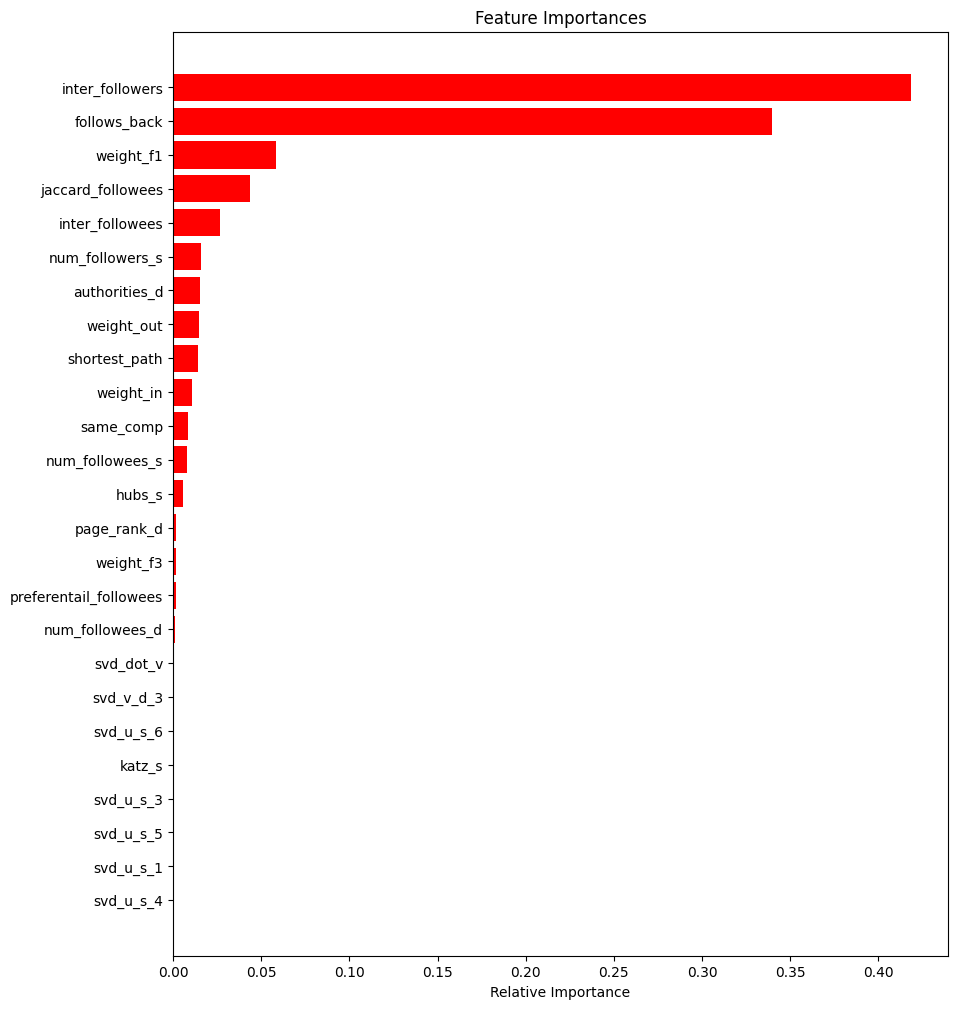

[CV 4/5; 4/10] START colsample_bytree=0.3, learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.1
[CV 4/5; 4/10] END colsample_bytree=0.3, learning_rate=0.15, max_depth=3, n_estimators=100, subsample=0.1;, score=0.975 total time=   6.8s
[CV 3/5; 5/10] START colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.3
[CV 3/5; 5/10] END colsample_bytree=0.5, learning_rate=0.2, max_depth=5, n_estimators=300, subsample=0.3;, score=0.980 total time=  25.0s
[CV 3/5; 1/10] START colsample_bytree=0.5, learning_rate=0.15, max_depth=3, n_estimators=200, subsample=0.5
[CV 3/5; 1/10] END colsample_bytree=0.5, learning_rate=0.15, max_depth=3, n_estimators=200, subsample=0.5;, score=0.976 total time=  10.0s
[CV 3/5; 7/10] START colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1
[CV 3/5; 7/10] END colsample_bytree=0.5, learning_rate=0.1, max_depth=7, n_estimators=200, subsample=1;, score=0.978 total time=  22.6s
[CV 4/5; 3/10] START

In [98]:
features = df_final_train.columns
importances = best_model.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()